In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np

from time import sleep
from tqdm import tqdm_notebook
from scipy.interpolate import spline

In [7]:
'''
Import data produced in previous scripts
'''
columns = ['contract_id', 'procuring_entity', 'procuring_entity_id',
       'procuring_entity_type', 'region', 'item_desc', 'cpv',
       'tender_id', 'procurement_type', 'tenderURL']
data_addcontr = pd.read_excel('04_output/potential_economy_v2.xlsx', sheet_name = 'Sheet1')

data_addcontr_raw = pd.read_excel('04_output/addcontr_all_clean_v1.5.xlsx', 'contracts_short')
data_contracts_raw = pd.read_excel('02_data/addcontr_gas_1mln_v2.xlsx')[columns].drop_duplicates()
data_contracts_dates = data_addcontr_raw[['contract_id','date_signed','contract_end']].drop_duplicates()
data_contracts = data_addcontr.groupby(by = 'contract_id')['expenses_fact','expenses_formula','potential_economy'].sum()
data_contracts['perc_economy'] = data_contracts.loc[:,'potential_economy']/data_contracts.loc[:,'expenses_fact']
print(data_contracts_raw.columns)
print(data_addcontr.columns)
print(data_contracts_dates.shape)
data_contracts.head()

Index(['contract_id', 'procuring_entity', 'procuring_entity_id',
       'procuring_entity_type', 'region', 'item_desc', 'cpv', 'tender_id',
       'procurement_type', 'tenderURL'],
      dtype='object')
Index(['contract_id', 'month', 'year', 'amount_1000m3', 'supply_implied',
       'start_date', 'addcontr_date', 'price', 'baseline_date',
       'baseline_price', 'price_change_noformula', 'expenses_fact',
       'exchange_rate_base', 'ncg_base', 'ncg_mean', 'exchange_rate_index',
       'ueb_baseline', 'ueb_index', 'price_formula', 'price_change_formula',
       'expenses_formula', 'potential_economy'],
      dtype='object')
(1210, 3)


,expenses_fact,expenses_formula,potential_economy,perc_economy
contract_id,,,,
001de2081beb4e6cbe967805f79ac92f,1.917854e+06,1.903807e+06,14046.568035,0.007324
00bd7256552349a48243e136576c6e0b,4.400155e+06,4.265746e+06,134408.789108,0.030546
00e9bb8f33ed4b188c707d596236f809,8.405672e+05,7.840289e+05,56538.261249,0.067262
01182e8dd7f44459be923c17cedf896b,1.334929e+06,1.273113e+06,61815.903213,0.046307
0118feb97c3d4c1ba4eaf8160382cd85,1.006493e+06,9.957085e+05,10784.646048,0.010715


In [106]:
#станом на січень вже неактуально
#докачати дати договорів
entry_point_contracts = 'https://public.api.openprocurement.org/api/2.4/contracts/'
contract_dates = []

for contract_id in tqdm_notebook(data_contracts['contract_id']):
    response_data = requests.get(entry_point_contracts + contract_id).json()['data']
    
    try:
        date_signed = pd.to_datetime(response_data['dateSigned'][:10])
    except:
        date_signed = 'unknown'
    
    try:
        date_end = pd.to_datetime(response_data['period']['endDate'][:10])
    except KeyError:
        date_end = 'unknown'
    
    contract_dates.append((contract_id,date_signed,date_end))
    sleep(0.2)

data_contract_dates = pd.DataFrame.from_records(contract_dates, columns = ['contract_id','date_signed','date_end'])
data_contract_dates.to_csv('contract_dates_proper.csv')
data_contract_dates.head()

,contract_id,date_signed,date_end
0,001de2081beb4e6cbe967805f79ac92f,2018-01-19,2018-12-31 00:00:00
1,00bd7256552349a48243e136576c6e0b,2018-01-29,2018-12-31 00:00:00
2,00e9bb8f33ed4b188c707d596236f809,2018-01-29,2018-12-31 00:00:00
3,01182e8dd7f44459be923c17cedf896b,2018-02-12,2018-12-31 00:00:00
4,0118feb97c3d4c1ba4eaf8160382cd85,2018-02-27,2018-12-31 00:00:00


In [4]:
'''
Create columns with initial and final prices for each contract
'''
contract_prices = []
for contract_id in tqdm_notebook(data_addcontr['contract_id'].unique()):
    
    current_contract = data_addcontr.loc[data_addcontr['contract_id'] == contract_id]
    min_date = min(current_contract['start_date'])
    max_date = max(current_contract['start_date'])
    
    start_price = int(current_contract.loc[current_contract['start_date'] == min_date]['baseline_price'])
    fin_price_formula = int(current_contract.loc[current_contract['start_date'] == max_date]['price_formula'])
    fin_price_noformula = int(current_contract.loc[current_contract['start_date'] == max_date]['price'])
    contract_prices.append((contract_id,start_price,fin_price_formula,fin_price_noformula))

data_contracts_prices = pd.DataFrame.from_records(contract_prices, columns = ['contract_id','start_price','fin_price_formula','fin_price_noformula'])
data_contracts_prices.head()

,contract_id,start_price,fin_price_formula,fin_price_noformula
0,001de2081beb4e6cbe967805f79ac92f,10380,13814,13814
1,00bd7256552349a48243e136576c6e0b,8871,14850,14850
2,00e9bb8f33ed4b188c707d596236f809,8400,8106,10155
3,01182e8dd7f44459be923c17cedf896b,8250,13038,13038
4,0118feb97c3d4c1ba4eaf8160382cd85,11151,12046,15004


In [8]:
'''
Create a dataframe with data for each contract:
1. De facto expenses
2. Expenses in case the indexation formula was applied
3. Potential economy
4. Potential economy in percent
5. Initial and final price
6. Dates the contract was signed and completed (terminated)
6. Other relevant data (procuring entity, procurement type, etc.)
'''
data_contracts = data_contracts.merge(data_contracts_prices, how='inner', on='contract_id')
data_contracts = data_contracts.merge(data_contracts_dates, how='inner', on='contract_id')
data_contracts = data_contracts.merge(data_contracts_raw, how='inner', on='contract_id')
print(data_contracts.shape)
print(data_contracts.columns)
data_contracts.head()

(1183, 19)
Index(['contract_id', 'expenses_fact', 'expenses_formula', 'potential_economy',
       'perc_economy', 'start_price', 'fin_price_formula',
       'fin_price_noformula', 'date_signed', 'contract_end',
       'procuring_entity', 'procuring_entity_id', 'procuring_entity_type',
       'region', 'item_desc', 'cpv', 'tender_id', 'procurement_type',
       'tenderURL'],
      dtype='object')


,contract_id,expenses_fact,expenses_formula,potential_economy,perc_economy,start_price,fin_price_formula,fin_price_noformula,date_signed,contract_end,procuring_entity,procuring_entity_id,procuring_entity_type,region,item_desc,cpv,tender_id,procurement_type,tenderURL
0,001de2081beb4e6cbe967805f79ac92f,1.917854e+06,1.903807e+06,14046.568035,0.007324,10380,13814,13814,2018-01-19,2018-12-31 00:00:00,КЗ Хмельницький обласний центр фізичного вихов...,22766553,general,Хмельницька область,природний газ,09120000-6,UA-2017-12-07-000132-b,aboveThresholdUA,https://prozorro.gov.ua/tender/UA-2017-12-07-0...
1,00bd7256552349a48243e136576c6e0b,4.400155e+06,4.265746e+06,134408.789108,0.030546,8871,14850,14850,2018-01-29,2018-12-31 00:00:00,ВІДДІЛ ОСВІТИ КРЕМЕНЕЦЬКОЇ РАЙОННОЇ ДЕРЖАВНОЇ ...,2145990,general,Тернопільська область,Природний газ,09120000-6,UA-2017-12-05-001157-c,aboveThresholdUA,https://prozorro.gov.ua/tender/UA-2017-12-05-0...
2,00e9bb8f33ed4b188c707d596236f809,8.405672e+05,7.840289e+05,56538.261249,0.067262,8400,8106,10155,2018-01-29,2018-12-31 00:00:00,Відділ освіти Жашківської районної державної а...,2147109,general,Черкаська область,природний газ,09120000-6,UA-2017-11-27-000324-a,aboveThresholdUA,https://prozorro.gov.ua/tender/UA-2017-11-27-0...
3,01182e8dd7f44459be923c17cedf896b,1.334929e+06,1.273113e+06,61815.903213,0.046307,8250,13038,13038,2018-02-12,2019-03-01 00:00:00,"КОМУНАЛЬНИЙ ВИЩИЙ НАВЧАЛЬНИЙ ЗАКЛАД ""УМАНСЬКИЙ...",2125645,general,Черкаська область,природний газ,09120000-6,UA-2018-01-26-000439-c,negotiation,https://prozorro.gov.ua/tender/UA-2018-01-26-0...
4,0118feb97c3d4c1ba4eaf8160382cd85,1.006493e+06,9.957085e+05,10784.646048,0.010715,11151,12046,15004,2018-02-27,2019-01-31 00:00:00,Відділ освіти Теребовлянської районної державн...,2146038,general,Тернопільська область,Природний газ,09123000-7,UA-2018-02-14-001194-a,negotiation,https://prozorro.gov.ua/tender/UA-2018-02-14-0...


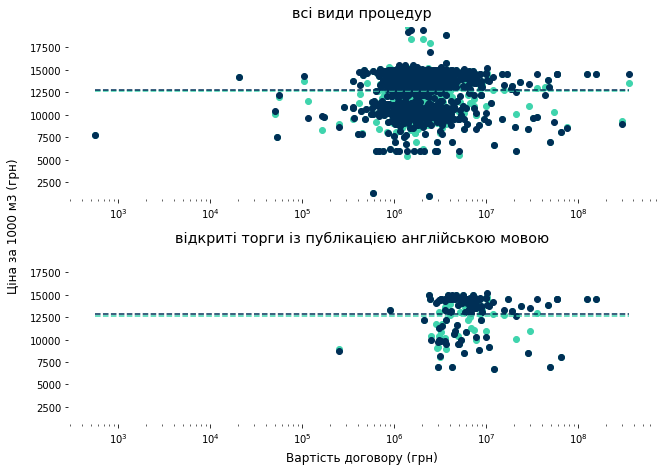

In [9]:
'''
Vizualize the difference in final prices with the use of indexation formula and without it
'''
def delete_frame(ax):
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212) 

delete_frame(ax)
delete_frame(ax1)
delete_frame(ax2)
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

x = data_contracts['expenses_fact']
minimal = x.min()
maximal = x.max()
y1 = data_contracts['fin_price_formula']
y2 = data_contracts['fin_price_noformula']
y_minimal = y1.min()-300
y_maximal = y2.max()+300
means = [y1.mean(),y2.mean()]
ax1.scatter(x, y1, c = '#3fd4ad')
ax1.plot([minimal,maximal], [means[0],means[0]], linestyle = '--', c = '#3fd4ad')
ax1.scatter(x, y2, c = '#002f56')
ax1.plot([minimal,maximal], [means[1],means[1]], linestyle = '--', c = '#002f56')
ax1.set_xscale('log')
ax1.set_ylim(y_minimal, y_maximal)

x = data_contracts.loc[data_contracts['procurement_type']=='aboveThresholdEU']['expenses_fact']
y1 = data_contracts.loc[data_contracts['procurement_type']=='aboveThresholdEU']['fin_price_formula']
y2 = data_contracts.loc[data_contracts['procurement_type']=='aboveThresholdEU']['fin_price_noformula']
means = [y1.mean(),y2.mean()]
ax2.scatter(x, y1, c = '#3fd4ad')
ax2.plot([minimal,maximal], [means[0],means[0]], linestyle = '--', c = '#3fd4ad')
ax2.scatter(x, y2, c = '#002f56')
ax2.plot([minimal,maximal], [means[1],means[1]], linestyle = '--', c = '#002f56')
ax2.set_xscale('log')
ax2.set_ylim(y_minimal, y_maximal)

ax.set_xlabel('Вартість договору (грн)', labelpad = 10, fontsize = 'large')
ax.set_ylabel('Ціна за 1000 м3 (грн)', labelpad = 25, fontsize = 'large')
#ax.set_title('Зниження ціни при індексації за формулою', pad = 35, fontsize = 'xx-large', color = '#3fd4ad')
ax1.set_title('всі види процедур', pad = 10, fontsize = 'x-large')
ax2.set_title('відкриті торги із публікацією англійською мовою', pad = 10, fontsize = 'x-large')

#plt.text(2000,3000,'Темно-синім кольором позначено фактично ціну газу за додатковими угодами, бірюзовим - ціну у випадку, якби відбувалася\nіндексація за формулою. Точки - конкретні договори, лінії - середня ціна.')
plt.tight_layout()
#plt.savefig('prices_decrease_fin6.png', dpi = 300)
plt.show()

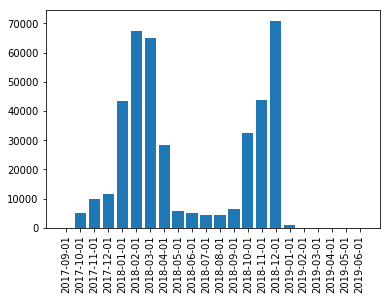

In [10]:
'''
Vizualize the distribution of supply amounts
'''
bar_data = data_addcontr.groupby(by = 'start_date')['amount_1000m3'].sum().reset_index()
#plt.bar(bar_data['start_date'],bar_data['amount_1000m3'])
plt.bar(bar_data['start_date'].map(lambda x: x.strftime(format = '%Y-%m-%d')),bar_data['amount_1000m3'])
plt.xticks(rotation='vertical')
plt.show()

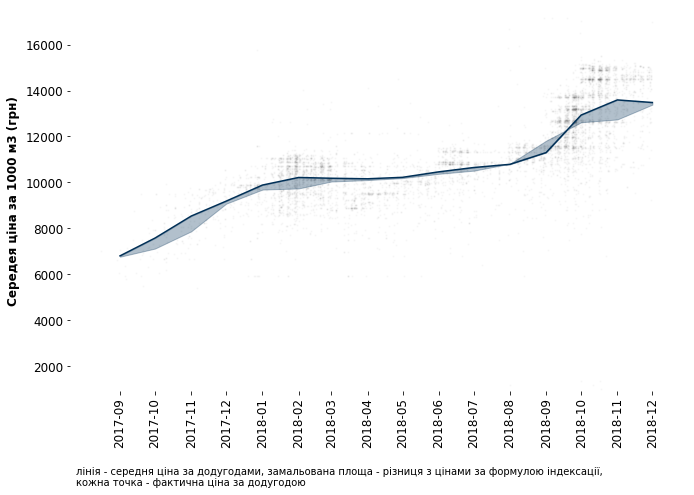

In [12]:
'''
Vizualize the monthly price changes with the use of indexation formula and without it
'''
price_fact = data_addcontr.loc[data_addcontr['start_date'] < pd.to_datetime('2019-01-01')].groupby(by = 'start_date')['price'].mean().reset_index()
price_formula = data_addcontr.loc[data_addcontr['start_date'] < pd.to_datetime('2019-01-01')].groupby(by = 'start_date')['price_formula'].mean().reset_index()

addcontr_points = data_addcontr_raw[['addcontr_date','price_addcontr']].loc[data_addcontr_raw['addcontr_date']<=pd.to_datetime('2018-12-01')]

x = price_formula['start_date'].values
y1 = price_formula['price_formula']
y2 = price_fact['price']

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)
ax.scatter(addcontr_points['addcontr_date'].values,addcontr_points['price_addcontr'],s=1,color='#666666', alpha=0.03)
ax.plot(x,y2,color='#002f56')
ax.fill_between(x,y1,y2,color='#002f56',alpha=0.3)
ax.tick_params(axis = 'x', labelrotation=90)
ax.tick_params(labelsize = 'large')
ax.set_xticks(x)
ax.set_xticklabels([str(label)[:7] for label in x])
ax.set_ylabel('Середея ціна за 1000 м3 (грн)', labelpad = 5, weight = 'bold', fontsize = 'large')
ax.set_ylim(addcontr_points['price_addcontr'].min(), 17500)
plt.text(0.01,-0.25,'лінія - середня ціна за додугодами, замальована площа - різниця з цінами за формулою індексації, \nкожна точка - фактична ціна за додугодою',transform=ax.transAxes)
delete_frame(ax)
#plt.savefig('05_viz/prices_increase_v2.png', dpi = 300, bbox_inches = 'tight')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  # Remove the CWD from sys.path while we load stuff.


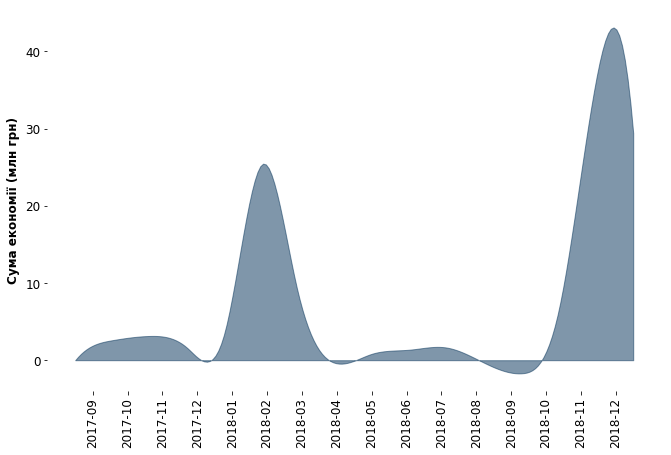

In [21]:
'''
Vizualize the monthly economy with the use of indexation formula and without it
'''
economy = data_addcontr.loc[data_addcontr['start_date']<=pd.to_datetime('2018-12-01')].groupby(by='start_date')['potential_economy','amount_1000m3'].sum().reset_index()

x = economy['start_date']
y = economy['potential_economy']

x_sm = np.asarray(x)
y_sm = np.array(y)

x_smooth = np.linspace(x.min().value, x.max().value, 200)
y_smooth = spline([i.value for i in x], y, x_smooth)

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)
ax.fill_between(x_smooth,y_smooth,0,color='#002f56',alpha=0.5)
ax.tick_params(axis = 'x', labelrotation =90)
ax.set_xticks([x_smooth.min() + (x_smooth.max()-x_smooth.min())*1/(len(x)*2) + (x_smooth.max()-x_smooth.min())*i/len(x) for i in range(len(x))])
ax.set_xticklabels([str(label)[:7] for label in x], fontsize = 'large')
ax.set_yticklabels([int(i/1000000) for i in ax.get_yticks()], fontsize = 'large')
ax.set_ylabel('Сума економії (млн грн)', labelpad = 5, weight = 'bold', fontsize = 'large')
delete_frame(ax)

#plt.savefig('05_viz/economy_v2.png', dpi = 300, bbox_inches = 'tight')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


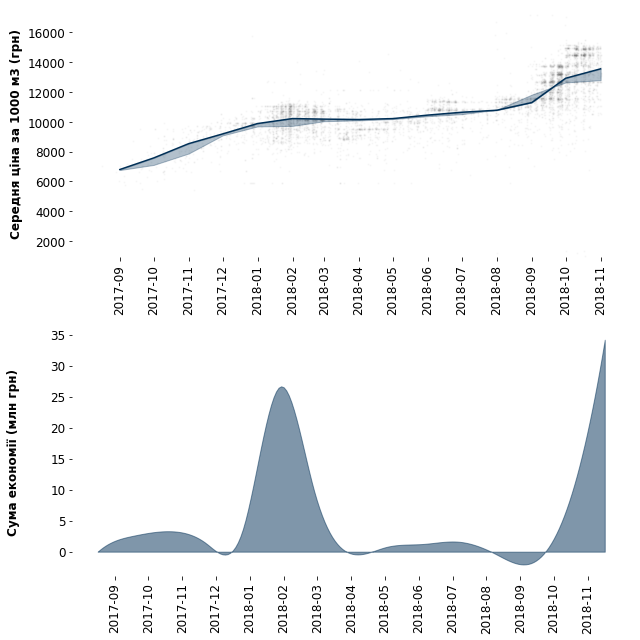

In [44]:
'''
Two previous vizualizations in one picture (for publication in "Вісник держзакупівель")
'''

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212) 

delete_frame(ax)
delete_frame(ax2)

x = price_formula['start_date'].values
y1 = price_formula['price_formula']
y2 = price_fact['price']

ax.scatter(addcontr_points['addcontr_date'].values,addcontr_points['price_addcontr'],s=1,color='#666666', alpha=0.03)
ax.plot(x,y2,color='#002f56')
ax.fill_between(x,y1,y2,color='#002f56',alpha=0.3)
ax.tick_params(axis = 'x', labelrotation=90)
ax.tick_params(labelsize = 'large')
ax.set_xticks(x)
ax.set_xticklabels([str(label)[:7] for label in x])
ax.set_ylabel('Середня ціна за 1000 м3 (грн)', labelpad = 5, weight = 'bold', fontsize = 'large')
ax.set_ylim(addcontr_points['price_addcontr'].min(), 17500)
#plt.text(0.01,-0.4,'лінія - середня ціна за додугодами, замальована площа - різниця з цінами за формулою індексації, \nкожна точка - фактична ціна за додугодою',transform=ax.transAxes)

economy = data_addcontr.groupby(by='start_date')['potential_economy','amount_1000m3'].sum().reset_index()

x_2 = economy['start_date']
y_2 = economy['potential_economy']

x_sm = np.asarray(x_2)
y_sm = np.array(y_2)

x_smooth = np.linspace(x_2.min().value, x_2.max().value, 200)
y_smooth = spline([i.value for i in x_2], y_2, x_smooth)

ax2.fill_between(x_smooth,y_smooth,0,color='#002f56',alpha=0.5)
ax2.tick_params(axis = 'x', labelrotation =90)
ax2.set_xticks([x_smooth.min() + (x_smooth.max()-x_smooth.min())*1/(len(x_2)*2) + (x_smooth.max()-x_smooth.min())*i/len(x_2) for i in range(len(x_2))])
ax2.set_xticklabels([str(label)[:7] for label in x_2], fontsize = 'large')
ax2.set_yticklabels([int(t/1000000) for t in ax2.get_yticks()], fontsize = 'large')
ax2.set_ylabel('Сума економії (млн грн)', labelpad = 30, weight = 'bold', fontsize = 'large')

plt.tight_layout()
plt.savefig('05_viz/price-economy_v1.0.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [24]:
'''
Difference in final prices with the use of indexation formula and without it
'''
print((data_contracts['fin_price_noformula'] - data_contracts['fin_price_formula']).mean())
data_euro = data_contracts.loc[data_contracts['procurement_type']=='aboveThresholdEU']
print((data_euro['fin_price_noformula'] - data_euro['fin_price_formula']).mean())

170.4792899408284
238.22429906542055


In [23]:
'''
Potential economy in percent
'''
data_contracts['potential_economy'].sum()/data_contracts['expenses_fact'].sum()

0.027494133895639365